# Capstone Project - The Battle of Neighborhoods (Final)

## 1. Introduction

### 1.1 Scenario and Background
I am a data scientist currently working in a Property Agency in Singapore. My boss, the stakeholder would like to know the flat price given the address of property, he wants me to predict the flat price without knowing other characteristics such as flat type, area, remaining lease and etc.

He also mention that the flat price may be highly related to the environment of the house. Generally, the living would be more convinient if your house is near the metro stations, schools or shopping malls, therefore, the flat price near the more venues would be higher. Moreover, the distance to downtown is also significant effect for house price, as the price will be higher for the properties located nearer downtown.  

In this project, I will apply the learned skills during the Coursera course to explore the venues around block address as features of training data and applied some regression algorithms to build the predictive models to solve this problem.

### 1.2 Challenge to Solve the Problem
The challenge to solve this problem is being able to find the venues around given the flat address as features to create the training dataset. Therefore, in order to obtain the all venues, there are some API that will be adopted in sloving this problem:
* OneMap API to obtain the coordinates for given flat addresses.
* FourSquare API to obtain the venues for each flat.

### 1.3 Interested Audience
I believe this is a relevant project for a Property Agency Company or Government House Agency who would like to predict the house price given the house address, thus, they are able to have some sense what is the house price for the flats to be transacted, subsequantly, they can advise the reasonable price to their potential house buyers or sellers, since the approach and methodologies used here are applicable in all other places. 

Lastly, this project is a good practical case toward the development of Data Science skills.

## 2. Data Section

### 2.1 Description of the Data

The following data is required to solve the issues:

* House transaction data from 2015 to 2019 which is downloaded from singapore government datasets website https://Data.gov.sg. As the house price has been stablizing during this period in singapore, this transaction data is appropriate for our study.
* Coordinates data for each flat from OneMap API.
* Venues data for each flat from FourSquare.

### 2.2 How the data will be used to solve the problem
The data will be used as follows:

* The price in the house transaction dataset is associated with flat area, In order to eliminate the effect of flat area, the transaction rate (price per square meter) for each flat will be computered. In addition, our study will concentrate on house block level which comprise of many flats, therefore, the median transaction rate at house block level is calculated and used as target variable for our machine learning models training.
 
* The OneMap API is used to obtain the coordinates data for each block address, the coordinates data are subsequently applied to FourSquare to fetch the venues data for each house block. Meanwhile the coordinated are also used to calculate the distance from each block location to center of Singapore as new created feature.

* Use Foursquare API to fetch the venues on categories 'Arts & Entertainment', 'Bus Stop', 'Food', 'Metro Station', 'School' and 'Shop & Service' for all house blocks and count the venues quantity(as per Course LAB), which is subsequently used as fatures for the machine learing models training.

In [153]:
#Import necessary packages
import pandas as pd
import numpy as np
import requests
import json
import io
import os
import time
from multiprocessing import Pool
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')

#### House Transaction Dataset downloaded from 'https://Data.gov.sg'

In [154]:
# Import data which is downloaded from 'https://Data.gov.sg'
df = pd.read_csv('resale-flat-prices-based-on-registration-date-from-jan-2015-onwards.csv')
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0


In [137]:
df.shape

(79100, 11)

In [6]:
# Look at the data details, seems like there is no missing data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79100 entries, 0 to 79099
Data columns (total 11 columns):
month                  79100 non-null object
town                   79100 non-null object
flat_type              79100 non-null object
block                  79100 non-null object
street_name            79100 non-null object
storey_range           79100 non-null object
floor_area_sqm         79100 non-null float64
flat_model             79100 non-null object
lease_commence_date    79100 non-null int64
remaining_lease        79100 non-null int64
resale_price           79100 non-null float64
dtypes: float64(2), int64(2), object(7)
memory usage: 6.6+ MB


In [152]:
#Create resale rate which is resale price per square meter
df['resale_rate'] = df.resale_price / df.floor_area_sqm

#Create new column 'flat_address'
df['flat_address'] = df['block'] + " " + df['street_name']
df = df[['resale_rate', 'flat_address']]
df.head()

,resale_rate,flat_address
0,4250.000000,174 ANG MO KIO AVE 4
1,4044.117647,541 ANG MO KIO AVE 10
2,4130.434783,163 ANG MO KIO AVE 4
3,4264.705882,446 ANG MO KIO AVE 10
4,4264.705882,557 ANG MO KIO AVE 10


#### Use OneMap API to obtain the coordinates for all house blocks

In [8]:
#Function to fetch data from OneMap
def fetch_data(searchVal):

    pageNum = 1
    results = []
    while True:
        try:
            response = requests.get('https://developers.onemap.sg/commonapi/search?searchVal={}&returnGeom=Y&getAddrDetails=Y&pageNum={}'.format(searchVal, str(pageNum)))
            response = response.json()
            print(searchVal)
        except requests.exceptions.ConnectionError as e:
            print('Fetching {} failed. Retrying in 2 sec'.format(street_name))
            time.sleep(2)
            continue
        
        if response['found'] == 0:
            response['results'] = [{'SEARCHVAL': 'NIL', 'BLK_NO': 'NIL', 'ROAD_NAME': 'NIL', 'BUILDING': 'NIL', 'ADDRESS': 'NIL', 'POSTAL': 'NIL', 'X': 'NIL', 'Y': 'NIL', 'LATITUDE': 'NIL', 'LONGITUDE': 'NIL', 'LONGTITUDE': 'NIL'}]
        else:
            pass

        for i in range(len(response['results'])):
            response['results'][i]['flat_address'] = searchVal

        results = results + response['results']

        if response['totalNumPages'] > pageNum:
            pageNum = pageNum + 1
        else:
            break
    return results

In [8]:
if __name__ == '__main__':
    pool = Pool(5)

    address = df["flat_address"].unique().tolist()
    data_fetched = pool.map(fetch_data, address)
    jstr = json.dumps([y for x in data_fetched for y in x], indent =2, sort_keys = True)

    #Write JSON file
    with io.open('flats_data.json', 'w', encoding='utf8') as f:
        f.write(jstr)

153 SERANGOON NTH AVE 1
469 ADMIRALTY DR
174 ANG MO KIO AVE 4
22 HOUGANG AVE 3
405 BT BATOK WEST AVE 7
469B ADMIRALTY DR
206 SERANGOON CTRL
2 HOUGANG AVE 3
541 ANG MO KIO AVE 10
330 BT BATOK ST 33
220 SERANGOON AVE 4
530 HOUGANG AVE 6
163 ANG MO KIO AVE 4
487 ADMIRALTY LINK
542 BT BATOK ST 52
446 ANG MO KIO AVE 10
263 SERANGOON CTRL DR
418 CANBERRA RD
307 HOUGANG AVE 5
121 BT BATOK CTRL
557 ANG MO KIO AVE 10
142 BT BATOK ST 11
484 ADMIRALTY LINK
121 HOUGANG AVE 1
603 ANG MO KIO AVE 5
140 BT BATOK ST 11
309 HOUGANG AVE 5
480 SEMBAWANG DR
709 ANG MO KIO AVE 8
245 SERANGOON AVE 2
404 ADMIRALTY LINK
317 HOUGANG AVE 7
7 TELOK BLANGAH CRES
333 ANG MO KIO AVE 1
242 HOUGANG ST 22
207 SERANGOON CTRL
421 CANBERRA RD
37 JLN RUMAH TINGGI
109 ANG MO KIO AVE 4
588C MONTREAL DR
109 SERANGOON NTH AVE 1
327 HOUGANG AVE 5
141 JLN BT MERAH
564 ANG MO KIO AVE 3
33 TELOK BLANGAH WAY
328 HOUGANG AVE 5
417 CANBERRA RD
103 SERANGOON NTH AVE 1
218 ANG MO KIO AVE 1
644 HOUGANG AVE 8
531 SERANGOON NTH AVE 4
324 

In [9]:
#Read JSON file
with open('flats_data.json', encoding='utf8') as data_file:
    address_data_loaded = json.load(data_file)

#Merge HDB transaction data with postcode and coordinates data together
address_data_df = pd.DataFrame(address_data_loaded)
address_data_df = address_data_df.drop_duplicates('flat_address')[['flat_address', 'LATITUDE', 'LONGITUDE']]
address_data_df.head()

,flat_address,LATITUDE,LONGITUDE
0,174 ANG MO KIO AVE 4,1.37509746867905,103.83761896123
1,541 ANG MO KIO AVE 10,1.3739223916883,103.855621371068
3,163 ANG MO KIO AVE 4,1.37354853919929,103.838176471398
7,446 ANG MO KIO AVE 10,1.36776095130956,103.855357145908
9,557 ANG MO KIO AVE 10,1.37162570203322,103.857736107527


In [10]:
#Create median resale rate for each flat block as target variable. 
median_resale_rate = df.groupby('flat_address').resale_rate.median().reset_index()

#Merge data together.
flat_resale_data = median_resale_rate.merge(address_data_df, on = 'flat_address', how = 'left')
flat_resale_data = flat_resale_data.loc[(flat_resale_data.LATITUDE!="NIL") | (flat_resale_data.LONGITUDE!="NIL"), :]
flat_resale_data = flat_resale_data.reset_index(drop=True)

#Shuffle data
flat_resale_data = flat_resale_data.sample(frac=1).reset_index(drop=True)

flat_resale_data.head()

,flat_address,resale_rate,LATITUDE,LONGITUDE
0,543 HOUGANG AVE 8,3728.155340,1.37785956993059,103.892020656191
1,331 JURONG EAST AVE 1,3915.175573,1.35082650419633,103.73042009299
2,222 PENDING RD,3408.756868,1.37521334525043,103.774095682531
3,521 ANG MO KIO AVE 5,5617.393720,1.37357054041248,103.851551329495
4,222 SERANGOON AVE 4,4741.320571,1.35842952473613,103.8712240101


In [48]:
flat_resale_data.to_csv('flats_price_data.csv', index = False)

#### Use FourSquare API to obtain the venues for house blocks
Since there is limitation of FourSquare calls per day, I will randomly select 1200 house blocks address as our samples, and use Foursquare API to get venues around for these 1200 house blocks.

In [179]:
CLIENT_ID = 'I2VM1WKFQxxxxxxxxxxxxx' # your Foursquare ID
CLIENT_SECRET = '2OALVQNxxxxxxxxxxx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [170]:
import foursquare   #Import foursquare library 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
fs = foursquare.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

In [76]:
# Select categories of Food, Shop & Service, Bus Stop, Metro Station, Arts & Enterainment, School as the venue features
fs_categories = {
    'Food': '4d4b7105d754a06374d81259',
    'Shop & Service': '4d4b7105d754a06378d81259',
    'Bus Stop': '52f2ab2ebcbc57f1066b8b4f',
    'Metro Station': '4bf58dd8d48988d1fd931735',
    'Arts & Entertainment': '4d4b7104d754a06370d81259',
    'School': '4bf58dd8d48988d13b941735'
}

In [171]:
# Define a function to search nearby venues and convert the result as dataframe,
# Set radius as 500m, around 5 minutes walking time
def venues_nearby(block_address, latitude, longitude, category, radius=500):    
    results = fs.venues.search(
        params = {
            'query': category, 
            'll': '{},{}'.format(latitude, longitude),
            'radius': radius,
            'categoryId': fs_categories[category]
        }
    )    
    df = json_normalize(results['venues'])
    cols = ['Flat_Address','Flat_Latitude', 'Flat_Longitude', 'Venues','Category','Venue_Latitude','Venue_Longitude']    
    if( len(df) == 0 ):        
        df = pd.DataFrame(columns=cols)
    else:        
        df = df[['name','location.lat','location.lng']]
        df.columns = ['Venues', 'Venue_Latitude', 'Venue_Longitude']
        df['Flat_Address'] = block_address
        df['Flat_Latitude'] = latitude
        df['Flat_Longitude'] = longitude
        df['Category'] = category
        df = df[cols]
#     if( verbose ):
#         print('{} "{}" venues are found within {}m of location'.format(len(df), category, RADIUS))
    return df

In [74]:
def getVenues(block_addresses, latitudes, longitudes):
    cols = ['Flat_Address','Flat_Latitude', 'Flat_Longitude', 'Venues','Category','Venue_Latitude','Venue_Longitude']
    df_venues = pd.DataFrame(columns = cols)
    for address, latitude, longitude in zip(block_addresses, latitudes, longitudes):
        venues = pd.DataFrame(columns = cols)
        for category in fs_categories:
            venues_cat = venues_nearby(address, latitude, longitude, category)
            venues = pd.concat([venues, venues_cat], ignore_index=True) 
        print('{} venues are found for "{}"'.format(len(venues), address))
        df_venues = pd.concat([df_venues, venues], ignore_index=True)
    return df_venues

In [56]:
flat_venues_150_1 = getVenues(block_addresses=flat_resale_data.loc[:150,'flat_address'],
                                   latitudes=flat_resale_data.loc[:150,'LATITUDE'],
                                   longitudes=flat_resale_data.loc[:150, 'LONGITUDE'])

24 venues are found for "543 HOUGANG AVE 8"
20 venues are found for "331 JURONG EAST AVE 1"
24 venues are found for "222 PENDING RD"
69 venues are found for "521 ANG MO KIO AVE 5"
20 venues are found for "222 SERANGOON AVE 4"
30 venues are found for "94 C'WEALTH DR"
15 venues are found for "317 HOUGANG AVE 7"
40 venues are found for "145 BEDOK RESERVOIR RD"
33 venues are found for "203B COMPASSVALE RD"
41 venues are found for "266C COMPASSVALE BOW"
17 venues are found for "985B BUANGKOK CRES"
13 venues are found for "6 FARRER RD"
21 venues are found for "188D RIVERVALE DR"
25 venues are found for "22 SIN MING RD"
40 venues are found for "61 NEW UPP CHANGI RD"
58 venues are found for "307C ANG MO KIO AVE 1"
39 venues are found for "655 YISHUN AVE 4"
32 venues are found for "770 BEDOK RESERVOIR VIEW"
67 venues are found for "108 YISHUN RING RD"
51 venues are found for "4B BOON TIONG RD"
20 venues are found for "133 POTONG PASIR AVE 1"
42 venues are found for "301C PUNGGOL CTRL"
58 venues

In [77]:
flat_venues_150_2 = getVenues(block_addresses=flat_resale_data.loc[151:300,'flat_address'],
                                   latitudes=flat_resale_data.loc[151:300,'LATITUDE'],
                                   longitudes=flat_resale_data.loc[151:300, 'LONGITUDE'])

35 venues are found for "633 ANG MO KIO AVE 6"
24 venues are found for "102 C'WEALTH CRES"
49 venues are found for "52 HAVELOCK RD"
42 venues are found for "422 FAJAR RD"
57 venues are found for "165 STIRLING RD"
54 venues are found for "36 JLN RUMAH TINGGI"
40 venues are found for "290D BT BATOK EAST AVE 3"
42 venues are found for "94 GEYLANG BAHRU"
13 venues are found for "180B RIVERVALE CRES"
20 venues are found for "4 UPP ALJUNIED LANE"
13 venues are found for "460 CHOA CHU KANG AVE 4"
34 venues are found for "41 BEDOK STH RD"
47 venues are found for "855 YISHUN RING RD"
35 venues are found for "152 SERANGOON NTH AVE 1"
65 venues are found for "210 NEW UPP CHANGI RD"
23 venues are found for "535 PASIR RIS DR 1"
25 venues are found for "65 TELOK BLANGAH DR"
26 venues are found for "474 ANG MO KIO AVE 10"
29 venues are found for "515A TAMPINES CTRL 7"
21 venues are found for "102 POTONG PASIR AVE 1"
28 venues are found for "4 GHIM MOH RD"
30 venues are found for "604 WOODLANDS DR 42"

In [40]:
flat_venues_150_3 = getVenues(block_addresses=flat_resale_data.loc[301:450,'flat_address'],
                                   latitudes=flat_resale_data.loc[301:450,'LATITUDE'],
                                   longitudes=flat_resale_data.loc[301:450, 'LONGITUDE'])

16 venues are found for "296B COMPASSVALE CRES"
30 venues are found for "14 DOVER CL EAST"
41 venues are found for "146 BEDOK RESERVOIR RD"
31 venues are found for "142 SERANGOON NTH AVE 1"
37 venues are found for "225 ANG MO KIO AVE 1"
32 venues are found for "420 CANBERRA RD"
48 venues are found for "426 FAJAR RD"
32 venues are found for "773 BEDOK RESERVOIR VIEW"
35 venues are found for "109D EDGEDALE PLAINS"
40 venues are found for "622A PUNGGOL CTRL"
46 venues are found for "7 LOR LEW LIAN"
28 venues are found for "606 ANG MO KIO AVE 5"
35 venues are found for "442 PASIR RIS DR 6"
19 venues are found for "27 DOVER CRES"
33 venues are found for "614 ANG MO KIO AVE 4"
42 venues are found for "665 WOODLANDS RING RD"
71 venues are found for "716 ANG MO KIO AVE 6"
22 venues are found for "330 JURONG EAST AVE 1"
55 venues are found for "112 C'WEALTH CRES"
31 venues are found for "243 KIM KEAT LINK"
33 venues are found for "643 HOUGANG AVE 8"
28 venues are found for "88 TELOK BLANGAH HTS

In [45]:
flat_venues_150_4 = getVenues(block_addresses=flat_resale_data.loc[451:600,'flat_address'],
                                   latitudes=flat_resale_data.loc[451:600,'LATITUDE'],
                                   longitudes=flat_resale_data.loc[451:600, 'LONGITUDE'])

23 venues are found for "168C SIMEI LANE"
26 venues are found for "616 BEDOK RESERVOIR RD"
34 venues are found for "109 GANGSA RD"
35 venues are found for "109 SERANGOON NTH AVE 1"
48 venues are found for "788 CHOA CHU KANG NTH 6"
14 venues are found for "664 CHOA CHU KANG CRES"
47 venues are found for "139 JLN BT MERAH"
29 venues are found for "317B ANCHORVALE RD"
38 venues are found for "112 BT BATOK WEST AVE 6"
23 venues are found for "347 KANG CHING RD"
46 venues are found for "354A ADMIRALTY DR"
58 venues are found for "126 ANG MO KIO AVE 3"
41 venues are found for "131B KIM TIAN RD"
38 venues are found for "264E COMPASSVALE BOW"
39 venues are found for "613 BT PANJANG RING RD"
42 venues are found for "209A COMPASSVALE LANE"
67 venues are found for "811 TAMPINES AVE 4"
50 venues are found for "9 HOLLAND AVE"
37 venues are found for "766 CHOA CHU KANG NTH 5"
48 venues are found for "65 KALLANG BAHRU"
55 venues are found for "7 BOON KENG RD"
40 venues are found for "201A COMPASSVALE

In [81]:
flat_venues_150_5 = getVenues(block_addresses=flat_resale_data.loc[601:750,'flat_address'],
                                   latitudes=flat_resale_data.loc[601:750,'LATITUDE'],
                                   longitudes=flat_resale_data.loc[601:750, 'LONGITUDE'])

19 venues are found for "602 BEDOK RESERVOIR RD"
38 venues are found for "609 BEDOK RESERVOIR RD"
11 venues are found for "280 TOH GUAN RD"
49 venues are found for "230 HOUGANG AVE 1"
56 venues are found for "191 LOR 4 TOA PAYOH"
46 venues are found for "110 BT BATOK WEST AVE 6"
27 venues are found for "20 JOO SENG RD"
22 venues are found for "20 DOVER CRES"
41 venues are found for "318 UBI AVE 1"
44 venues are found for "234 CHOA CHU KANG CTRL"
52 venues are found for "124 GEYLANG EAST AVE 1"
52 venues are found for "241 BT PANJANG RING RD"
27 venues are found for "402 BT BATOK WEST AVE 7"
42 venues are found for "320D ANCHORVALE DR"
18 venues are found for "453 SIN MING AVE"
35 venues are found for "704 WOODLANDS DR 40"
23 venues are found for "335 HOUGANG AVE 7"
48 venues are found for "652 WOODLANDS RING RD"
21 venues are found for "27 JLN BAHAGIA"
58 venues are found for "413 BEDOK NTH AVE 2"
49 venues are found for "423 FAJAR RD"
34 venues are found for "410 HOUGANG AVE 10"
19 ve

In [85]:
flat_venues_150_6 = getVenues(block_addresses=flat_resale_data.loc[751:900,'flat_address'],
                                   latitudes=flat_resale_data.loc[751:900,'LATITUDE'],
                                   longitudes=flat_resale_data.loc[751:900, 'LONGITUDE'])

13 venues are found for "706 HOUGANG AVE 2"
46 venues are found for "201 CHOA CHU KANG AVE 1"
28 venues are found for "131 MARSILING RISE"
19 venues are found for "295A COMPASSVALE CRES"
28 venues are found for "521 SERANGOON NTH AVE 4"
48 venues are found for "636 CHOA CHU KANG NTH 6"
33 venues are found for "637 HOUGANG AVE 8"
41 venues are found for "213 ANG MO KIO AVE 3"
37 venues are found for "321 SEMBAWANG CL"
21 venues are found for "304 SHUNFU RD"
36 venues are found for "632 BEDOK RESERVOIR RD"
50 venues are found for "682C JURONG WEST CTRL 1"
55 venues are found for "23 JLN MEMBINA"
42 venues are found for "143 BEDOK RESERVOIR RD"
34 venues are found for "20 BEDOK STH RD"
54 venues are found for "32 HOLLAND CL"
15 venues are found for "702 HOUGANG AVE 2"
12 venues are found for "213C PUNGGOL WALK"
32 venues are found for "18 EUNOS CRES"
54 venues are found for "538 JURONG WEST AVE 1"
47 venues are found for "729 ANG MO KIO AVE 6"
27 venues are found for "20 BALAM RD"
38 venu

In [124]:
flat_venues_150_7 = getVenues(block_addresses=flat_resale_data.loc[901:1050,'flat_address'],
                                   latitudes=flat_resale_data.loc[901:1050,'LATITUDE'],
                                   longitudes=flat_resale_data.loc[901:1050, 'LONGITUDE'])

57 venues are found for "575 ANG MO KIO AVE 10"
43 venues are found for "121 HOUGANG AVE 1"
40 venues are found for "461 PASIR RIS DR 4"
44 venues are found for "540 JELAPANG RD"
20 venues are found for "436A FERNVALE RD"
37 venues are found for "202A COMPASSVALE DR"
33 venues are found for "647 PUNGGOL CTRL"
26 venues are found for "642B PUNGGOL DR"
30 venues are found for "518B TAMPINES CTRL 7"
21 venues are found for "130 EDGEDALE PLAINS"
58 venues are found for "30 HOLLAND CL"
61 venues are found for "45 HOLLAND DR"
33 venues are found for "362 CLEMENTI AVE 2"
36 venues are found for "425 SERANGOON AVE 1"
40 venues are found for "129 BEDOK RESERVOIR RD"
20 venues are found for "186B RIVERVALE DR"
43 venues are found for "120 HOUGANG AVE 1"
33 venues are found for "310 SHUNFU RD"
34 venues are found for "26 MARSILING DR"
56 venues are found for "115A YISHUN RING RD"
21 venues are found for "740 BEDOK RESERVOIR RD"
15 venues are found for "589B MONTREAL DR"
60 venues are found for "2

In [110]:
flat_venues_150_8 = getVenues(block_addresses=flat_resale_data.loc[1051:1200,'flat_address'],
                                   latitudes=flat_resale_data.loc[1051:1200,'LATITUDE'],
                                   longitudes=flat_resale_data.loc[1051:1200, 'LONGITUDE'])

29 venues are found for "413 C'WEALTH AVE WEST"
42 venues are found for "25 TELOK BLANGAH CRES"
43 venues are found for "2 JLN BATU"
34 venues are found for "101 RIVERVALE WALK"
41 venues are found for "611 BT PANJANG RING RD"
26 venues are found for "705 BEDOK NTH RD"
14 venues are found for "154 YUNG HO RD"
29 venues are found for "952 HOUGANG AVE 9"
32 venues are found for "59 STRATHMORE AVE"
22 venues are found for "136 PETIR RD"
30 venues are found for "618 HOUGANG AVE 8"
40 venues are found for "682B JURONG WEST CTRL 1"
22 venues are found for "110C PUNGGOL FIELD"
30 venues are found for "408 SEMBAWANG DR"
46 venues are found for "107 TOWNER RD"
37 venues are found for "858 TAMPINES AVE 5"
22 venues are found for "307A ANCHORVALE RD"
26 venues are found for "44 OWEN RD"
42 venues are found for "785 CHOA CHU KANG DR"
33 venues are found for "340 CLEMENTI AVE 5"
51 venues are found for "443 JURONG WEST AVE 1"
86 venues are found for "739 YISHUN AVE 5"
31 venues are found for "255 A

In [114]:
flat_venues_150_9 = getVenues(block_addresses=flat_resale_data.loc[1201:1350,'flat_address'],
                                   latitudes=flat_resale_data.loc[1201:1350,'LATITUDE'],
                                   longitudes=flat_resale_data.loc[1201:1350, 'LONGITUDE'])

36 venues are found for "302 HOUGANG AVE 5"
20 venues are found for "264 BOON LAY DR"
46 venues are found for "18 TOH YI DR"
63 venues are found for "671A KLANG LANE"
36 venues are found for "488 JURONG WEST AVE 1"
24 venues are found for "543 SERANGOON NTH AVE 3"
34 venues are found for "408 HOUGANG AVE 10"
35 venues are found for "588 WOODLANDS DR 16"
40 venues are found for "310 CANBERRA RD"
39 venues are found for "23 MARSILING DR"
22 venues are found for "23 DOVER CRES"
41 venues are found for "109 HOUGANG AVE 1"
18 venues are found for "430C FERNVALE LINK"
31 venues are found for "542 HOUGANG AVE 8"
42 venues are found for "506 HOUGANG AVE 8"
49 venues are found for "702 WEST COAST RD"
31 venues are found for "201D COMPASSVALE DR"
24 venues are found for "412 C'WEALTH AVE WEST"
34 venues are found for "649 HOUGANG AVE 8"
24 venues are found for "20 TEBAN GDNS RD"
29 venues are found for "232 COMPASSVALE WALK"
46 venues are found for "174 BT BATOK WEST AVE 8"
43 venues are found f

In [132]:
flat_venues_150_10 = getVenues(block_addresses=flat_resale_data.loc[1351:1500,'flat_address'],
                                   latitudes=flat_resale_data.loc[1351:1500,'LATITUDE'],
                                   longitudes=flat_resale_data.loc[1351:1500, 'LONGITUDE'])

39 venues are found for "300 CANBERRA RD"
52 venues are found for "417 CHOA CHU KANG AVE 4"
24 venues are found for "401 ADMIRALTY LINK"
39 venues are found for "604B PUNGGOL RD"
45 venues are found for "673A CHOA CHU KANG CRES"
69 venues are found for "206 SERANGOON CTRL"
28 venues are found for "260 BT BATOK EAST AVE 4"
58 venues are found for "7 EVERTON PK"
6 venues are found for "201 PETIR RD"
32 venues are found for "895B WOODLANDS DR 50"
37 venues are found for "645 HOUGANG AVE 8"
19 venues are found for "135 LOR AH SOO"
39 venues are found for "715 WOODLANDS DR 70"
55 venues are found for "133 GEYLANG EAST AVE 1"
18 venues are found for "631 SENJA RD"
37 venues are found for "111 TECK WHYE LANE"
28 venues are found for "632 WOODLANDS RING RD"
32 venues are found for "633B PUNGGOL DR"
30 venues are found for "221 LOR 8 TOA PAYOH"
45 venues are found for "161 LOR 1 TOA PAYOH"
27 venues are found for "631 PASIR RIS DR 3"
42 venues are found for "3D UPP BOON KENG RD"
21 venues are f

In [141]:
flat_venues_150_11 = getVenues(block_addresses=flat_resale_data.loc[1501:1650,'flat_address'],
                                   latitudes=flat_resale_data.loc[1501:1650,'LATITUDE'],
                                   longitudes=flat_resale_data.loc[1501:1650, 'LONGITUDE'])

47 venues are found for "6 LOR 7 TOA PAYOH"
34 venues are found for "611 ANG MO KIO AVE 5"
41 venues are found for "310A ANG MO KIO AVE 1"
35 venues are found for "96 WHAMPOA DR"
18 venues are found for "308A ANCHORVALE RD"
14 venues are found for "159A RIVERVALE CRES"
40 venues are found for "107 TECK WHYE LANE"
51 venues are found for "559 ANG MO KIO AVE 10"
23 venues are found for "165B PUNGGOL CTRL"
35 venues are found for "358 HOUGANG AVE 5"
30 venues are found for "41 JLN BAHAGIA"
33 venues are found for "44 MARINE CRES"
54 venues are found for "30 MARINE CRES"
56 venues are found for "232 CHOA CHU KANG CTRL"
41 venues are found for "618B PUNGGOL DR"
12 venues are found for "157C RIVERVALE CRES"
27 venues are found for "338 WOODLANDS AVE 1"
42 venues are found for "650 WOODLANDS RING RD"
67 venues are found for "76 MARINE DR"
30 venues are found for "329 JURONG EAST AVE 1"
39 venues are found for "623 BT BATOK CTRL"
15 venues are found for "689A CHOA CHU KANG DR"
38 venues are fo

In [164]:
flat_venues_150_12 = getVenues(block_addresses=flat_resale_data.loc[1651:1800,'flat_address'],
                                   latitudes=flat_resale_data.loc[1651:1800,'LATITUDE'],
                                   longitudes=flat_resale_data.loc[1651:1800, 'LONGITUDE'])

61 venues are found for "85B LOR 4 TOA PAYOH"
38 venues are found for "489 JURONG WEST AVE 1"
34 venues are found for "176A EDGEFIELD PLAINS"
42 venues are found for "128 BEDOK RESERVOIR RD"
31 venues are found for "618 SENJA RD"
54 venues are found for "405 SERANGOON AVE 1"
46 venues are found for "518 JELAPANG RD"
30 venues are found for "678 CHOA CHU KANG CRES"
26 venues are found for "43 STIRLING RD"
50 venues are found for "530 JELAPANG RD"
55 venues are found for "28 TIONG BAHRU RD"
53 venues are found for "561 ANG MO KIO AVE 10"
34 venues are found for "232 PENDING RD"
31 venues are found for "18 ST. GEORGE'S RD"
50 venues are found for "421 FAJAR RD"
62 venues are found for "170 STIRLING RD"
41 venues are found for "106 BT BATOK CTRL"
50 venues are found for "411 ANG MO KIO AVE 10"
30 venues are found for "225C COMPASSVALE WALK"
33 venues are found for "721 WOODLANDS CIRCLE"
39 venues are found for "231 SERANGOON AVE 3"
41 venues are found for "27 GHIM MOH LINK"
36 venues are f

In [168]:
flat_venues_150_13 = getVenues(block_addresses=flat_resale_data.loc[1801:1950,'flat_address'],
                                   latitudes=flat_resale_data.loc[1801:1950,'LATITUDE'],
                                   longitudes=flat_resale_data.loc[1801:1950, 'LONGITUDE'])

8 venues are found for "477 SEGAR RD"
49 venues are found for "420 SERANGOON CTRL"
53 venues are found for "28 NEW UPP CHANGI RD"
53 venues are found for "418 CHOA CHU KANG AVE 4"
49 venues are found for "512 WOODLANDS DR 14"
48 venues are found for "225 LOR 8 TOA PAYOH"
11 venues are found for "485B CHOA CHU KANG AVE 5"
33 venues are found for "896B WOODLANDS DR 50"
21 venues are found for "685C CHOA CHU KANG CRES"
31 venues are found for "511 SERANGOON NTH AVE 4"
45 venues are found for "108B MCNAIR RD"
38 venues are found for "508 WOODLANDS DR 14"
29 venues are found for "15 TOH YI DR"
34 venues are found for "804 CHAI CHEE RD"
15 venues are found for "210 PETIR RD"
15 venues are found for "435 HOUGANG AVE 8"
20 venues are found for "217 PETIR RD"
40 venues are found for "103 BT BATOK CTRL"
58 venues are found for "69 LOR 4 TOA PAYOH"
20 venues are found for "630 WOODLANDS RING RD"
13 venues are found for "8 EMPRESS RD"
39 venues are found for "165 YISHUN RING RD"
37 venues are foun

Error connecting with foursquare API: HTTPSConnectionPool(host='api.foursquare.com', port=443): Max retries exceeded with url: /v2/venues/search?query=Metro%20Station&ll=1.4456879899150499,103.80069395076&radius=500&categoryId=4bf58dd8d48988d1fd931735&v=20190216&client_id=MYAGETUGWZU3DJCFHG1C5RJDQJHKD5UTATR3U1AUER5XTXRZ&client_secret=RARB433XILAP3TVCGFSF0JTZCDP1UEGNXEQ2XQ24EIAEZTQK (Caused by SSLError(SSLError("bad handshake: SysCallError(54, 'ECONNRESET')",),))


28 venues are found for "786B WOODLANDS DR 60"
38 venues are found for "692A CHOA CHU KANG CRES"
11 venues are found for "464 UPP SERANGOON RD"
18 venues are found for "724 BEDOK RESERVOIR RD"
54 venues are found for "46 LOR 5 TOA PAYOH"
69 venues are found for "710 ANG MO KIO AVE 8"
27 venues are found for "540 HOUGANG AVE 8"
39 venues are found for "351B CANBERRA RD"
41 venues are found for "255 BANGKIT RD"
88 venues are found for "740 YISHUN AVE 5"
23 venues are found for "615 HOUGANG AVE 8"
41 venues are found for "187 BT BATOK WEST AVE 6"
37 venues are found for "390 TAMPINES AVE 7"
46 venues are found for "2 HAIG RD"
20 venues are found for "689A WOODLANDS DR 75"
26 venues are found for "231 COMPASSVALE WALK"
22 venues are found for "69 TELOK BLANGAH HTS"
74 venues are found for "636 VEERASAMY RD"
61 venues are found for "82 LOR 4 TOA PAYOH"
34 venues are found for "363 HOUGANG AVE 5"
44 venues are found for "540 ANG MO KIO AVE 10"
30 venues are found for "612D PUNGGOL DR"
62 ven

In [172]:
flat_venues_150_14 = getVenues(block_addresses=flat_resale_data.loc[1951:2100,'flat_address'],
                                   latitudes=flat_resale_data.loc[1951:2100,'LATITUDE'],
                                   longitudes=flat_resale_data.loc[1951:2100, 'LONGITUDE'])

58 venues are found for "120 YISHUN RING RD"
35 venues are found for "411 HOUGANG AVE 10"
56 venues are found for "73 LOR 4 TOA PAYOH"
32 venues are found for "21 CHAI CHEE RD"
37 venues are found for "117 TECK WHYE LANE"
31 venues are found for "132 CHOA CHU KANG AVE 1"
37 venues are found for "222 ANG MO KIO AVE 1"
60 venues are found for "84B LOR 2 TOA PAYOH"
52 venues are found for "4A BOON TIONG RD"
38 venues are found for "666 JLN DAMAI"
23 venues are found for "251 HOUGANG AVE 3"
42 venues are found for "534 WOODLANDS DR 14"
29 venues are found for "141 LOR AH SOO"
57 venues are found for "9 BEDOK STH AVE 2"
28 venues are found for "609 ANG MO KIO AVE 4"
27 venues are found for "113 BT PURMEI RD"
37 venues are found for "424 BT BATOK WEST AVE 2"
52 venues are found for "117 BT MERAH CTRL"
55 venues are found for "3 EVERTON PK"
39 venues are found for "401 SERANGOON AVE 1"
29 venues are found for "541 HOUGANG AVE 8"
25 venues are found for "627 PASIR RIS DR 3"
40 venues are found

In [173]:
flat_venues = pd.concat([
                        flat_venues_150_1,
                        flat_venues_150_2, 
                        flat_venues_150_3,
                        flat_venues_150_4,
                        flat_venues_150_5, 
                        flat_venues_150_6,
                        flat_venues_150_7,
                        flat_venues_150_8, 
                        flat_venues_150_9,
                        flat_venues_150_10,
                        flat_venues_150_11, 
                        flat_venues_150_12,                    
                        flat_venues_150_13,
                        flat_venues_150_14
                        ], ignore_index=True)

In [178]:
cols = ['Flat_Address','Flat_Latitude', 'Flat_Longitude', 'Venues','Category','Venue_Latitude','Venue_Longitude']
flat_venues = flat_venues[cols]
flat_venues.to_csv('flat_venues.csv')
print(flat_venues.shape)
flat_venues.head()

(77634, 7)


,Flat_Address,Flat_Latitude,Flat_Longitude,Venues,Category,Venue_Latitude,Venue_Longitude
0,543 HOUGANG AVE 8,1.37786,103.892021,21 Food Loft,Food,1.378898,103.887984
1,543 HOUGANG AVE 8,1.37786,103.892021,Fu Fa Food Court,Food,1.379626,103.887903
2,543 HOUGANG AVE 8,1.37786,103.892021,Food Court,Food,1.374471,103.890869
3,543 HOUGANG AVE 8,1.37786,103.892021,A place with food,Food,1.375623,103.891191
4,543 HOUGANG AVE 8,1.37786,103.892021,Tao's Western Food,Food,1.373995,103.891053


In [180]:
# Let's calculate how many venues for each category of individual house block
venues = flat_venues.groupby(['Flat_Address', 'Category']).size().unstack()
venues = venues.rename_axis(None, axis=1).reset_index()
venues.fillna(0, inplace=True)
venues.head()

,Flat_Address,Arts & Entertainment,Bus Stop,Food,Metro Station,School,Shop & Service
0,1 CHAI CHEE RD,0.0,4.0,30.0,0.0,5.0,8.0
1,1 DOVER RD,1.0,1.0,8.0,0.0,4.0,3.0
2,1 GHIM MOH RD,1.0,2.0,14.0,0.0,3.0,7.0
3,1 KG KAYU RD,8.0,3.0,30.0,1.0,6.0,4.0
4,1 LOR 7 TOA PAYOH,0.0,4.0,30.0,0.0,7.0,6.0


In [181]:
#Merge venues data with house median resale rate and coordinates together.
flat_venues_data = flat_resale_data.merge(venues, left_on = 'flat_address', right_on = 'Flat_Address', how='left').dropna()
flat_venues_data.drop(['flat_address'], axis=1, inplace=True)
flat_venues_data.head()

,resale_rate,LATITUDE,LONGITUDE,Flat_Address,Arts & Entertainment,Bus Stop,Food,Metro Station,School,Shop & Service
0,3728.155340,1.377860,103.892021,543 HOUGANG AVE 8,1.0,3.0,9.0,0.0,3.0,8.0
1,3915.175573,1.350827,103.730420,331 JURONG EAST AVE 1,0.0,0.0,7.0,0.0,7.0,6.0
2,3408.756868,1.375213,103.774096,222 PENDING RD,1.0,2.0,12.0,0.0,1.0,8.0
3,5617.393720,1.373571,103.851551,521 ANG MO KIO AVE 5,0.0,3.0,30.0,0.0,9.0,27.0
4,4741.320571,1.358430,103.871224,222 SERANGOON AVE 4,0.0,2.0,7.0,0.0,2.0,9.0


## 3. Data Visulization 

In [182]:
# Use geocode to get singapore downtown coordinate
address = 'Singapore Raffles Place'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore CBD is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Singapore CBD is 1.2835947, 103.851568.


In [184]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around Ecco


# add Ecco as a red circle mark
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup='',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(venues_map)


# # add popular spots to the map as blue circle markers
flat_coord = flat_venues_data[['LATITUDE', 'LONGITUDE']].astype(float)
# venues_coord = flat_venues[['Venue_Latitude', 'Venue_Longitude']].astype(float)

for lat, lng in zip(flat_coord['LATITUDE'], flat_coord['LONGITUDE']):
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup='',
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

## 4. Methodology
Methodology section represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, and what machine learnings were used and why.

For this problem, since the object I study is resale rate given the flat address, I can use regression technique to solve the problem.

Prior to building the machine learning models, I have to conduct the feature engineering and apply some data analysis to explore the appropriate features for fitting models in order to gain best model performance.

## 5. Feature Engineering

### 5.1 Feature Creation
Calculate distance between each block and downtown, create new feature.

In [185]:
slat = np.radians(flat_venues_data.LATITUDE.astype(float).values)
slon = np.radians(flat_venues_data.LONGITUDE.astype(float).values)
elat = np.radians(latitude)
elon = np.radians(longitude)

flat_venues_data['Distance'] = 6371.01 * np.arccos(np.sin(slat)*np.sin(elat) + np.cos(slat)*np.cos(elat)*np.cos(slon - elon))

In [186]:
flat_venues_data.head()

,resale_rate,LATITUDE,LONGITUDE,Flat_Address,Arts & Entertainment,Bus Stop,Food,Metro Station,School,Shop & Service,Distance
0,3728.155340,1.377860,103.892021,543 HOUGANG AVE 8,1.0,3.0,9.0,0.0,3.0,8.0,11.405713
1,3915.175573,1.350827,103.730420,331 JURONG EAST AVE 1,0.0,0.0,7.0,0.0,7.0,6.0,15.403301
2,3408.756868,1.375213,103.774096,222 PENDING RD,1.0,2.0,12.0,0.0,1.0,8.0,13.340031
3,5617.393720,1.373571,103.851551,521 ANG MO KIO AVE 5,0.0,3.0,30.0,0.0,9.0,27.0,10.004873
4,4741.320571,1.358430,103.871224,222 SERANGOON AVE 4,0.0,2.0,7.0,0.0,2.0,9.0,8.603372


### 5.2 Data Transformation
Let's check the statistics and data distribution of target variable(i.e. median resale rate)

In [187]:
flat_venues_data.resale_rate.describe(include='all')

count     2101.000000
mean      4573.411604
std       1060.702897
min       2851.819590
25%       3818.181818
50%       4315.068493
75%       5094.339623
max      10892.473118
Name: resale_rate, dtype: float64

Resale rate is ranged from 2852 to 10892 with mean value of 4573. 

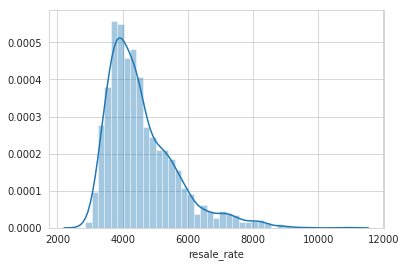

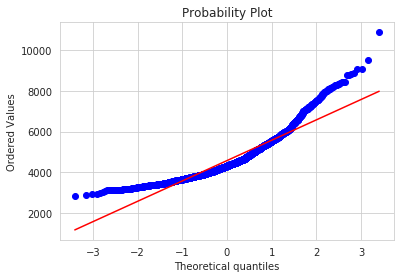

In [188]:
#Histogram and probability plots to check distribution
data = flat_venues_data['resale_rate']
sns.distplot(data, hist=True)
fig = plt.figure()
res = stats.probplot(data, plot=plt)

From the plots above, It is evident that the data distribution of variable 'resale_rate' is left skewed, which could make our machine learning performance worse, I will proceed logrithm data transformation for this variable.

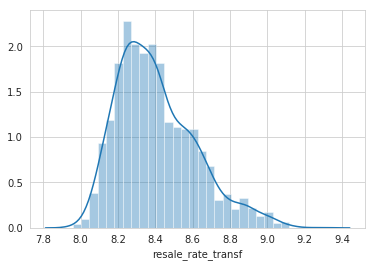

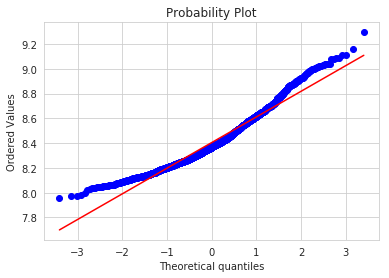

In [189]:
#Seems the data of 'resale_price' is left skewed, we will proceed logrithm data transformation
flat_venues_data['resale_rate_transf'] = np.log1p(flat_venues_data['resale_rate'])

#Histogram and normal probability plot to check distribution again.
data = flat_venues_data['resale_rate_transf']
sns.distplot(data, hist=True);
fig = plt.figure()
res = stats.probplot(data, plot=plt)

Now the target variable data is more normal distributed.

## 6.0 Exploratory Data Analysis

Since all of the features that to be employed in machine learning training are numerical data, we can plot scatter graphs with regression line to explore the relationships between each features and target variable.

In [190]:
col_sel = ['Arts & Entertainment', 'Bus Stop', 'Food', 'Metro Station', 'School', 'Shop & Service', 'Distance', 'resale_rate_transf']

flat_venues_sub = flat_venues_data[col_sel]

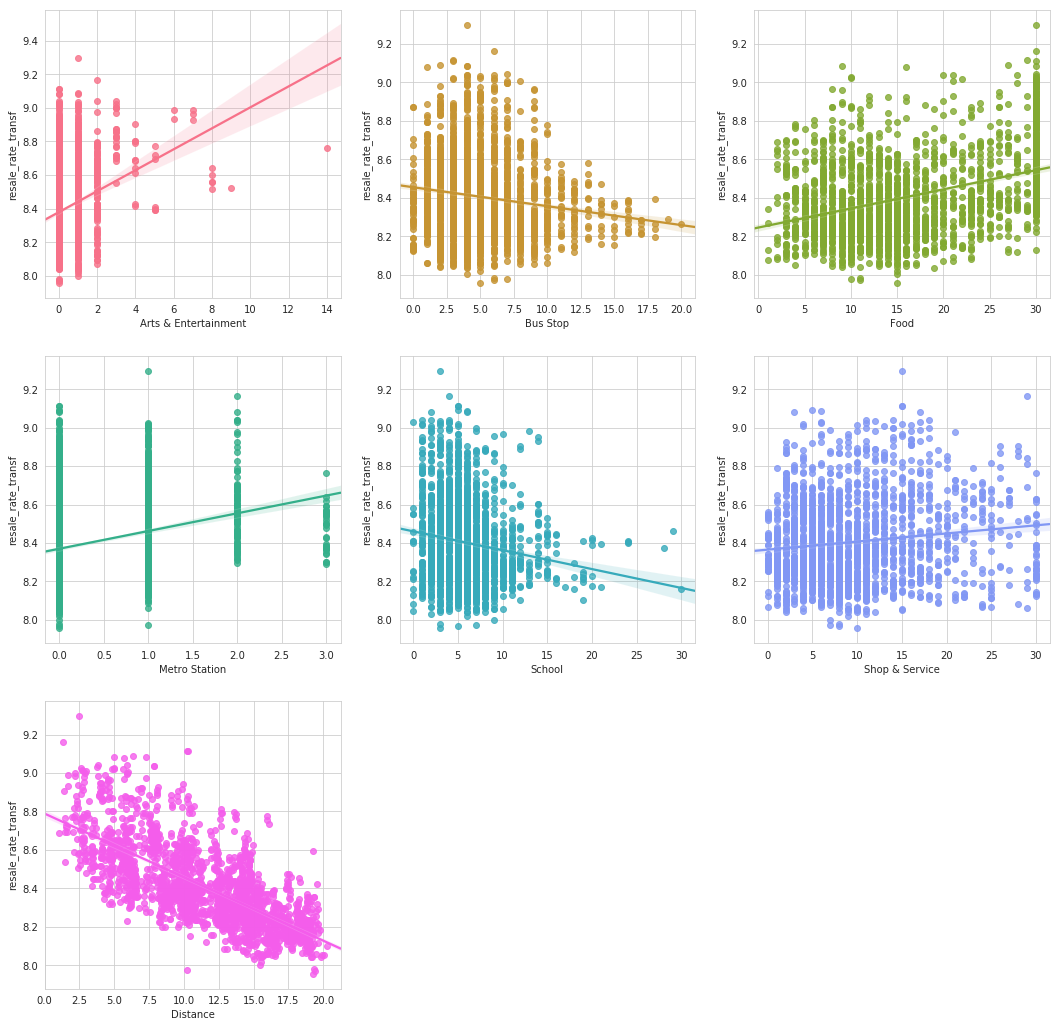

In [191]:
fig = plt.subplots(ncols=len(col_sel)-1, figsize=(18,18))
palette = iter(sns.husl_palette(len(col_sel)-1))
for ind, col in enumerate(col_sel[:-1]):
    plt.subplot(3, 3, ind+1)
    sns.regplot(x=col, y='resale_rate_transf', data=flat_venues_sub, color=next(palette))

From the figures above, It is found that there are no evident correlation between resale_rate and venues except distance variable, which is negative correlated to resale_rate, let's plot the heatmap to explore the correlations deeper.

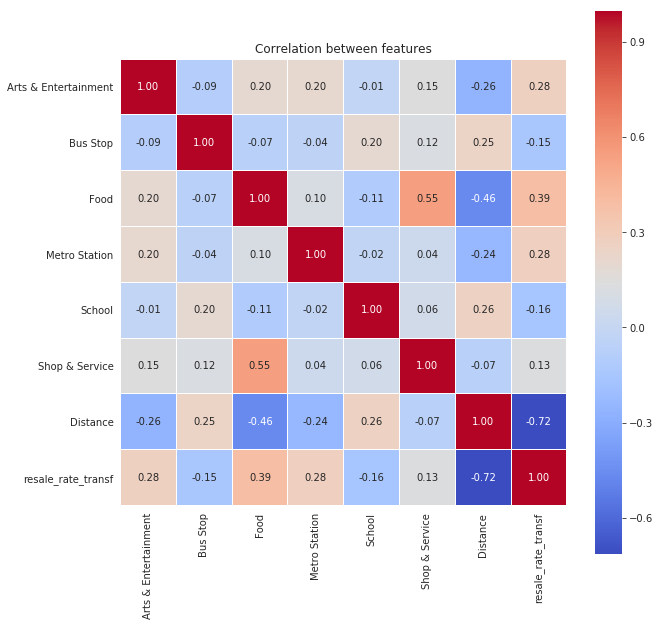

Sorted Correlation:
resale_rate_transf      1.000000
Food                    0.390430
Metro Station           0.282993
Arts & Entertainment    0.276290
Shop & Service          0.130957
Bus Stop               -0.146226
School                 -0.156098
Distance               -0.715434
Name: resale_rate_transf, dtype: float64


In [192]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(flat_venues_sub.corr(), annot=True, linewidth=0.01, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation between features')
plt.show()
print('Sorted Correlation:\n{}'.format(flat_venues_sub.corr()['resale_rate_transf'].sort_values(ascending=False)))

Heatmap plot for correlations above show us that any feature pairs (exclusive of target variable) are not highly correlated, which is meaning that there are no redundant features, while every feature is correlating to target variable.

## 7. Model Analysis

### 7.1 Feature Selection
With regarding to the Sec.6.0 above, the features about all venue categories and distance will be selected to fit the machine learning models.  

### 7.2 Train Test Sets Split
The prepared data is splited into training set(80% of data) and test set(20%), the training set will be used to train the regression models and do validation and parameter tuning, while test data will be used to model evaluation.

In [193]:
#split to training data and test data 
X = flat_venues_sub.drop(['resale_rate_transf'], axis = 1)
y = flat_venues_sub['resale_rate_transf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print('\nShape of All Sets:')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


Shape of All Sets:
(1680, 7) (1680,) (421, 7) (421,)


### 7.3 Model Training and Validation
Since the data is very small due to FourSquare API limitations, the following algorithms are selected to train models and evaluated.
* Linear regression
* Decision tree regressor
* Random forest regressor
* XGboost regressor
* LightGBM regressor

For the gradient descent based algorithm such as linear regression, the data shall be normlized prior to fitting models, I will apply StandScaler to normalize the data. 

In [98]:
#Model selection
#Linear regression considering fixed effect of town has been selected for baseline.
#For better fit for categorical data, tree based algorithms, RandomForest, XGBoost and LightGBM have been selected for fitting models.
import xgboost as xgb
import lightgbm as lgb
#Linear regression
lr = make_pipeline(StandardScaler(), LinearRegression())

#Decision Tree Regression model
dt = DecisionTreeRegressor()

#Random Forest Regression model
rf = RandomForestRegressor(n_estimators = 300,
                           bootstrap = True,
                           random_state = 5)

#XGBoost Regression model
xgb = xgb.XGBRegressor(colsample_bytree=0.6, 
                       learning_rate=0.05,  
                       n_estimators=300,
                       max_depth = 5,
                       booster = 'gbtree',
                       random_state =5)

#Light Gradient Boosting Machine Regression Model
lgb = lgb.LGBMRegressor(objective='regression', 
                        num_leaves=150,
                        max_depth = 5,
                        learning_rate=0.05,
                        num_iterations = 300,
                        n_estimators=300,
                        max_bin = 255, 
                        bagging_fraction = 0.8,
                        bagging_freq = 5, 
                        feature_fraction = 0.8)

models = []
models.append(('LR', lr))
models.append(('DT', dt))
models.append(('RF', rf))
models.append(('XGB', xgb))
models.append(('LGB', lgb))

In [58]:
#Fit all models through 5 fold cross validation, using mean square error as evaluation measures.
def validation(models, X, y):
    print('Model Performance - Mean Squared Error')
    for name, model in models:
        cv_results = -cross_val_score(model, X, y.values, scoring = 'neg_mean_squared_error', cv = 5)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

In [67]:
#Select best performed model to do evaluation for test data
def evaluation(best_model, model_name, X_train, y_train, X_test, y_test):
    #Evaluation of best model performance.
    best_model.fit(X_train.values, y_train.values)
    predictions = best_model.predict(X_test.values)
    msr = mean_squared_error(y_test, predictions)
    real_pred = np.exp(predictions)
    real_target = np.exp(y_test)  
    errors = abs(real_pred - real_target)
    mape = 100 * np.mean(errors / real_target)
    acc = 100 - mape

    print("'" + model_name + "'" + ' Model Performance')
    print('Mean Squared Error(log transformed): {:0.4f}.'.format(msr))
    print('Average Error: {:0.2f}.'.format(np.mean(errors)))
    print('Average Resale Rate: {:0.1f}.'.format(np.mean(real_target)))
    print('Accuracy = {:0.2f}%.'.format(acc))

In [194]:
#Model validation
validation(models, X_train, y_train)

Model Performance - Mean Squared Error
LR: 0.020166 (0.001669)
DT: 0.024394 (0.002984)
RF: 0.012845 (0.000821)
XGB: 0.014815 (0.001090)
LGB: 0.014541 (0.001024)


### 7.4 Model Evaluation

In [195]:
#Evaluate best performed model using test set and get out of sample performance.
best_model = rf
model_name = 'RF'
evaluation(best_model, 
                      model_name, 
                      X_train, 
                      y_train, 
                      X_test, 
                      y_test)

'RF' Model Performance
Mean Squared Error(log transformed): 0.0149.
Average Error: 417.67.
Average Resale Rate: 4572.7.
Accuracy = 91.52%.


## 8. Discussion

The results show us the prediction error is only 417.7 dollars/m2, which is minor comparing to the mean resale rate 4573 dollars/m2, and the accuracy is up to 0.915. Therefore, it is deemed that the model trained is able to perform very well for out of samples as well.

However, we have to admit that the data utilized in the models training is too small to reflect some insights, and that may make the models trained biased. In order to improve our model performance, more venue data shall be collected from FourSquare.

Furthermore, more time should also be spent on exploration of more venue categories such as entertainment place, wet market(specific market in singapore), and etc. 

Lastly, with expanding of our training dataset, the Artificial Neural Network could be explored and applied in this project to make performance better.

## 9. Conclusion

The problem of house price prediction is one of crucial problem for the private property agency and government house agency. With the house price predicted, stakeholds would carry out comparison with actual price to check whether the price is reasonable or not, or suggest most reasonable house price to potential flat buyer or seller to fulfill customer's demands, consequently improve business profitability.

In this project, I have conducted an effective feature engineering technique by applying FourSquare API to obtain the venue category features and corresponding data. With combination with another new created feature, i.e. Distance, the training dataset is then created to fit the regression model. In the model traning, validation and evaluation sections, it can be seen that the model trained achieved very good performance. Therefore the stakeholder's problem would be solved with deployment of this model.